In [1]:
import kagglehub

# This will download into the default KaggleHub cache (under /root/.cache/kagglehub)
path = kagglehub.dataset_download("jangedoo/utkface-new")

# Move the dataset to /content
import shutil
import os

# Get the folder name from the path
folder_name = os.path.basename(path)
target_path = f"/content/{folder_name}"

# Copy to /content
shutil.copytree(path, target_path, dirs_exist_ok=True)

print("Dataset copied to:", target_path)


Dataset copied to: /content/utkface-new


In [4]:
import os
from collections import defaultdict

def count_file_types_per_folder_inclusive(root_path):
    folder_filetype_counts = {}

    for entry in os.scandir(root_path):
        if entry.is_dir():
            folder_name = entry.name
            filetype_counts = defaultdict(int)

            for root, _, files in os.walk(entry.path):
                for file in files:
                    ext = os.path.splitext(file)[1].lower()
                    filetype_counts[ext] += 1

            folder_filetype_counts[folder_name] = dict(filetype_counts)

    return folder_filetype_counts

# Example usage
folder_path = "/content/utkface-new"
counts = count_file_types_per_folder_inclusive(folder_path)

# Display the results
for folder, filetypes in counts.items():
    print(f"\n📁 Folder: {folder}")
    if filetypes:
        for filetype, count in filetypes.items():
            print(f"  {filetype if filetype else '[No Extension]'}: {count}")
    else:
        print("  (No files found)")



📁 Folder: UTKFace
  .jpg: 23708

📁 Folder: crop_part1
  .jpg: 9780

📁 Folder: utkface_aligned_cropped
  .jpg: 33488


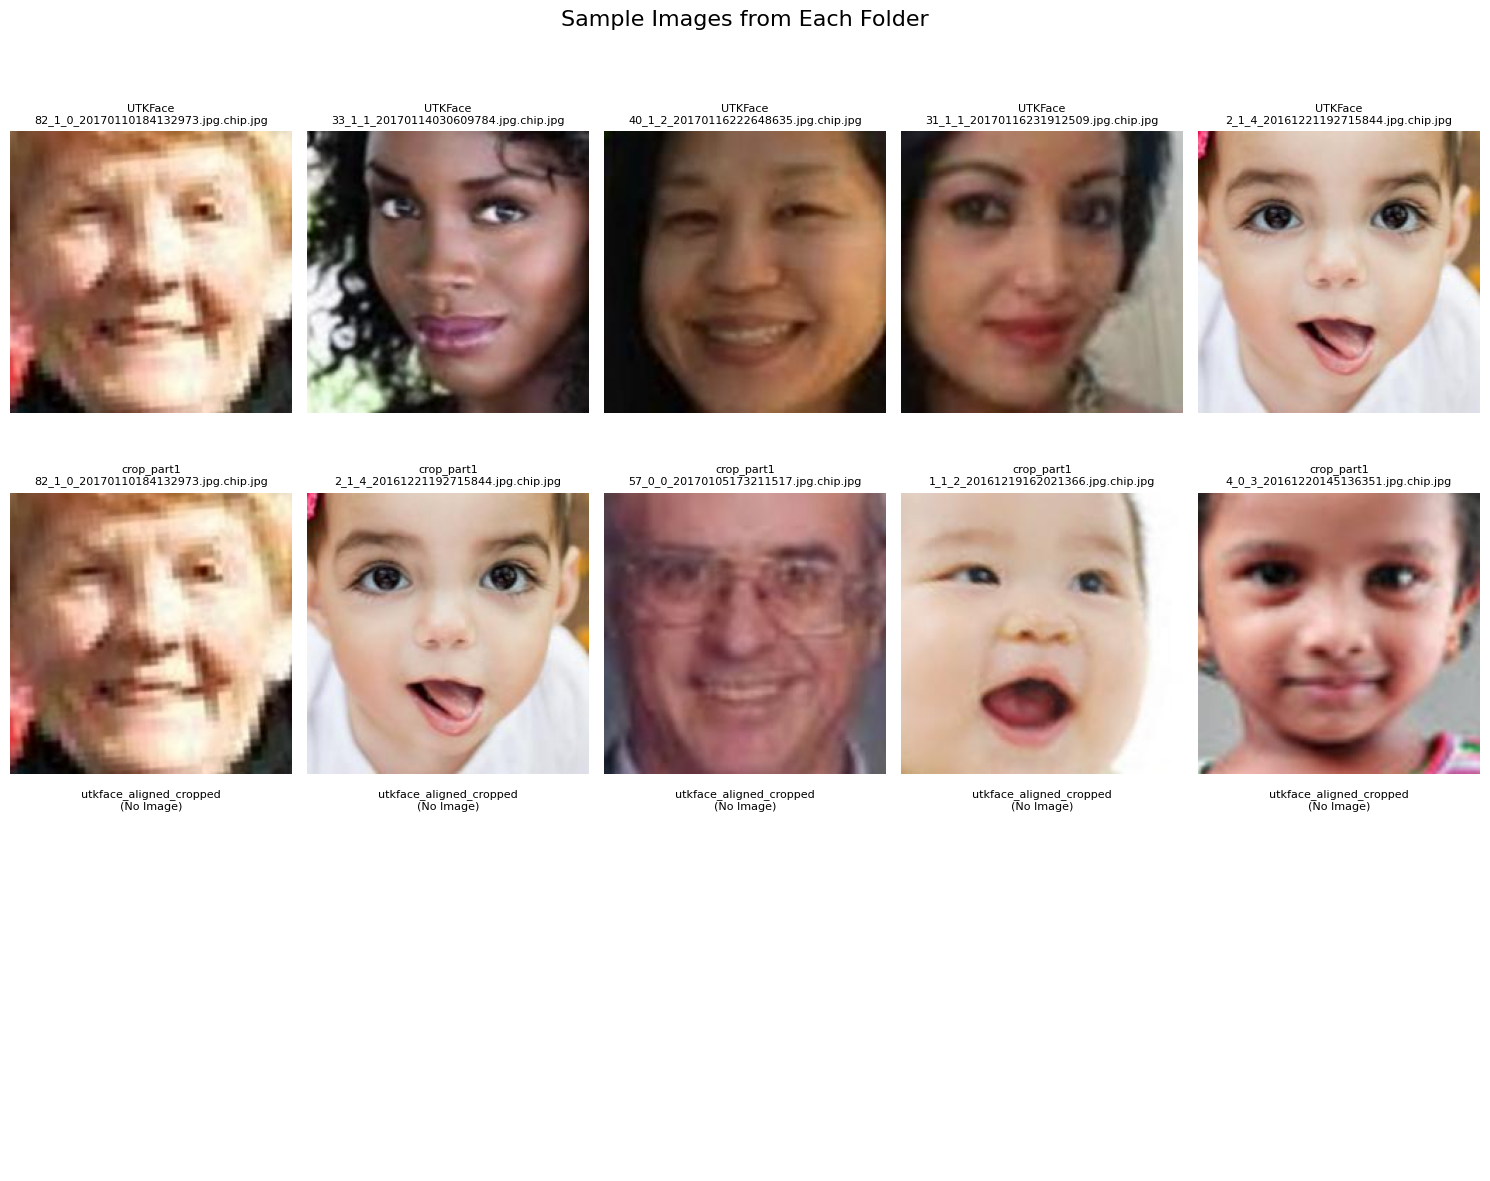

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set base directory and folder names
base_dir = "/content/utkface-new"
folders = ["UTKFace", "crop_part1", "utkface_aligned_cropped"]
images_per_folder = 5

# Prepare subplot grid (handle fewer images gracefully)
fig, axs = plt.subplots(len(folders), images_per_folder, figsize=(15, 4 * len(folders)))
fig.suptitle("Sample Images from Each Folder", fontsize=16)

for row, folder in enumerate(folders):
    folder_path = os.path.join(base_dir, folder)
    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    num_images = min(images_per_folder, len(files))  # Prevent index error

    for col in range(images_per_folder):
        ax = axs[row][col] if len(folders) > 1 else axs[col]

        if col < num_images:
            img_path = os.path.join(folder_path, files[col])
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"{folder}\n{files[col]}", fontsize=8)
        else:
            ax.set_title(f"{folder}\n(No Image)", fontsize=8)

        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [7]:
import os
import pandas as pd

def parse_utkface_filenames(folder_path):
    data = []
    for file in os.listdir(folder_path):
        if file.endswith(".jpg"):
            try:
                parts = file.split("_")
                age = int(parts[0])
                gender = int(parts[1])
                data.append([file, age, gender])
            except:
                continue  # skip malformed filenames

    return pd.DataFrame(data, columns=["filename", "age", "gender"])

# Combine from all subfolders
base_path = "/content/utkface-new"
folders = ["UTKFace", "crop_part1", "utkface_aligned_cropped"]

df_list = []
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    df = parse_utkface_filenames(folder_path)
    df["folder"] = folder
    df_list.append(df)

df_all = pd.concat(df_list, ignore_index=True)
print(df_all.head())


                                filename age gender   folder
0  82_1_0_20170110184132973.jpg.chip.jpg  82      1  UTKFace
1  33_1_1_20170114030609784.jpg.chip.jpg  33      1  UTKFace
2  40_1_2_20170116222648635.jpg.chip.jpg  40      1  UTKFace
3  31_1_1_20170116231912509.jpg.chip.jpg  31      1  UTKFace
4   2_1_4_20161221192715844.jpg.chip.jpg   2      1  UTKFace


In [8]:
import shutil

merged_folder = "/content/utkface_merged"
os.makedirs(merged_folder, exist_ok=True)

csv_data = []

for i, row in df_all.iterrows():
    src = os.path.join(base_path, row['folder'], row['filename'])
    dst_filename = f"{i}_{row['filename']}"
    dst = os.path.join(merged_folder, dst_filename)

    try:
        shutil.copy(src, dst)
        csv_data.append([dst_filename, row['age'], row['gender']])
    except:
        continue  # handle missing files if any

# Save labels
labels_df = pd.DataFrame(csv_data, columns=["filename", "age", "gender"])
labels_df.to_csv("/content/utkface_labels.csv", index=False)

print("✅ Merged and saved label CSV.")


✅ Merged and saved label CSV.


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image settings
img_size = 128

# Create image generator with labels
df = pd.read_csv("/content/utkface_labels.csv")
df["gender"] = df["gender"].astype(str)  # Keras requires labels as string

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

train_gen = datagen.flow_from_dataframe(
    df,
    directory="/content/utkface_merged",
    x_col="filename",
    y_col="gender",
    subset="training",
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode="binary"
)

val_gen = datagen.flow_from_dataframe(
    df,
    directory="/content/utkface_merged",
    x_col="filename",
    y_col="gender",
    subset="validation",
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode="binary"
)


ValueError: If class_mode="binary" there must be 2 classes. Found 3 classes.

In [10]:
print(df["gender"].unique())
print(df["gender"].value_counts())


['1' '0' '3']
gender
0    16763
1    16724
3        1
Name: count, dtype: int64


In [32]:
# Keep only gender 0 and 1
df = df[df["gender"].isin(["0", "1"])].copy()

# Optional: double-check
print("Remaining gender values:", df["gender"].unique())


Remaining gender values: ['1' '0']


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image settings
img_size = 128

# Create image generator with labels

df["gender"] = df["gender"].astype(str)  # Keras requires labels as string

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

train_gen = datagen.flow_from_dataframe(
    df,
    directory="/content/utkface_merged",
    x_col="filename",
    y_col="gender",
    subset="training",
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode="binary"
)

val_gen = datagen.flow_from_dataframe(
    df,
    directory="/content/utkface_merged",
    x_col="filename",
    y_col="gender",
    subset="validation",
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode="binary"
)


Found 26790 validated image filenames belonging to 2 classes.
Found 6697 validated image filenames belonging to 2 classes.


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_size, img_size, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_gen, validation_data=val_gen, epochs=5)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


837/838 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7210 - loss: 0.5290

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


838/838 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.7212 - loss: 0.5288 - val_accuracy: 0.8555 - val_loss: 0.3230
Epoch 2/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.8497 - loss: 0.3260 - val_accuracy: 0.8847 - val_loss: 0.2655
Epoch 3/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.8792 - loss: 0.2708 - val_accuracy: 0.9003 - val_loss: 0.2398
Epoch 4/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.8949 - loss: 0.2372 - val_accuracy: 0.9067 - val_loss: 0.2267
Epoch 5/5
838/838 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.9121 - loss: 0.2049 - val_accuracy: 0.9176 - val_loss: 0.2227


In [14]:
model.save("/content/gender_classifier_utkface.h5")


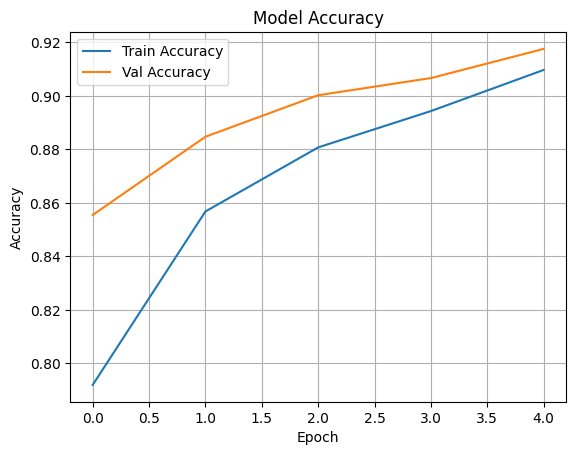

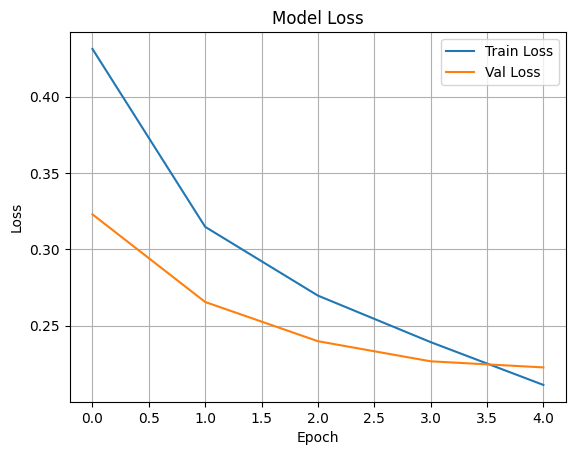

In [15]:
import matplotlib.pyplot as plt

history = model.history.history

plt.plot(history["accuracy"], label="Train Accuracy")
plt.plot(history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


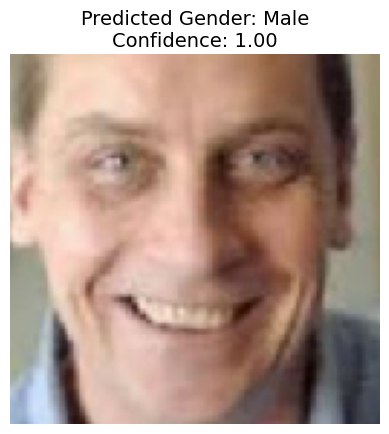

In [23]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
img_path = "/content/utkface_merged/10419_35_0_0_20170117130045470.jpg.chip.jpg"
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img) / 255.0
img_array_expanded = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array_expanded)[0][0]
gender = "Female" if pred > 0.5 else "Male"
confidence = pred if pred > 0.5 else 1 - pred

# Plot the image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Gender: {gender}\nConfidence: {confidence:.2f}", fontsize=14)
plt.show()
